In [31]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

In [4]:
baseflow = pd.read_csv("RRCA_baseflow.csv")
# Adjust date to be since 1900
baseflow["Date_Adjusted"] = baseflow["Date"] - 693963
baseflow.head(3)


,Date,Segment_id,x,y,Evapotranspiration,Precipitation,Irrigation_pumping,Observed,Date_Adjusted
0,710732,144,1086190,14476800,0.59,18.99,0.0,0.145161,16769
1,710763,144,1086190,14476800,0.97,29.63,0.0,0.445161,16800
2,710791,144,1086190,14476800,1.34,29.63,0.0,1.332203,16828


## Data Exploration

In [12]:
len(baseflow["Segment_id"].unique())

42

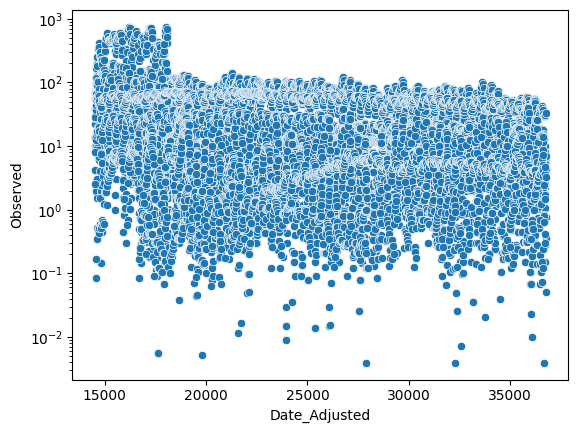

In [16]:
sns.scatterplot(data=baseflow, x='Date_Adjusted', y="Observed")
plt.yscale('log')

## Regression Plots of all Features

Text(0.5, 1.0, 'Feature Regression Plots')

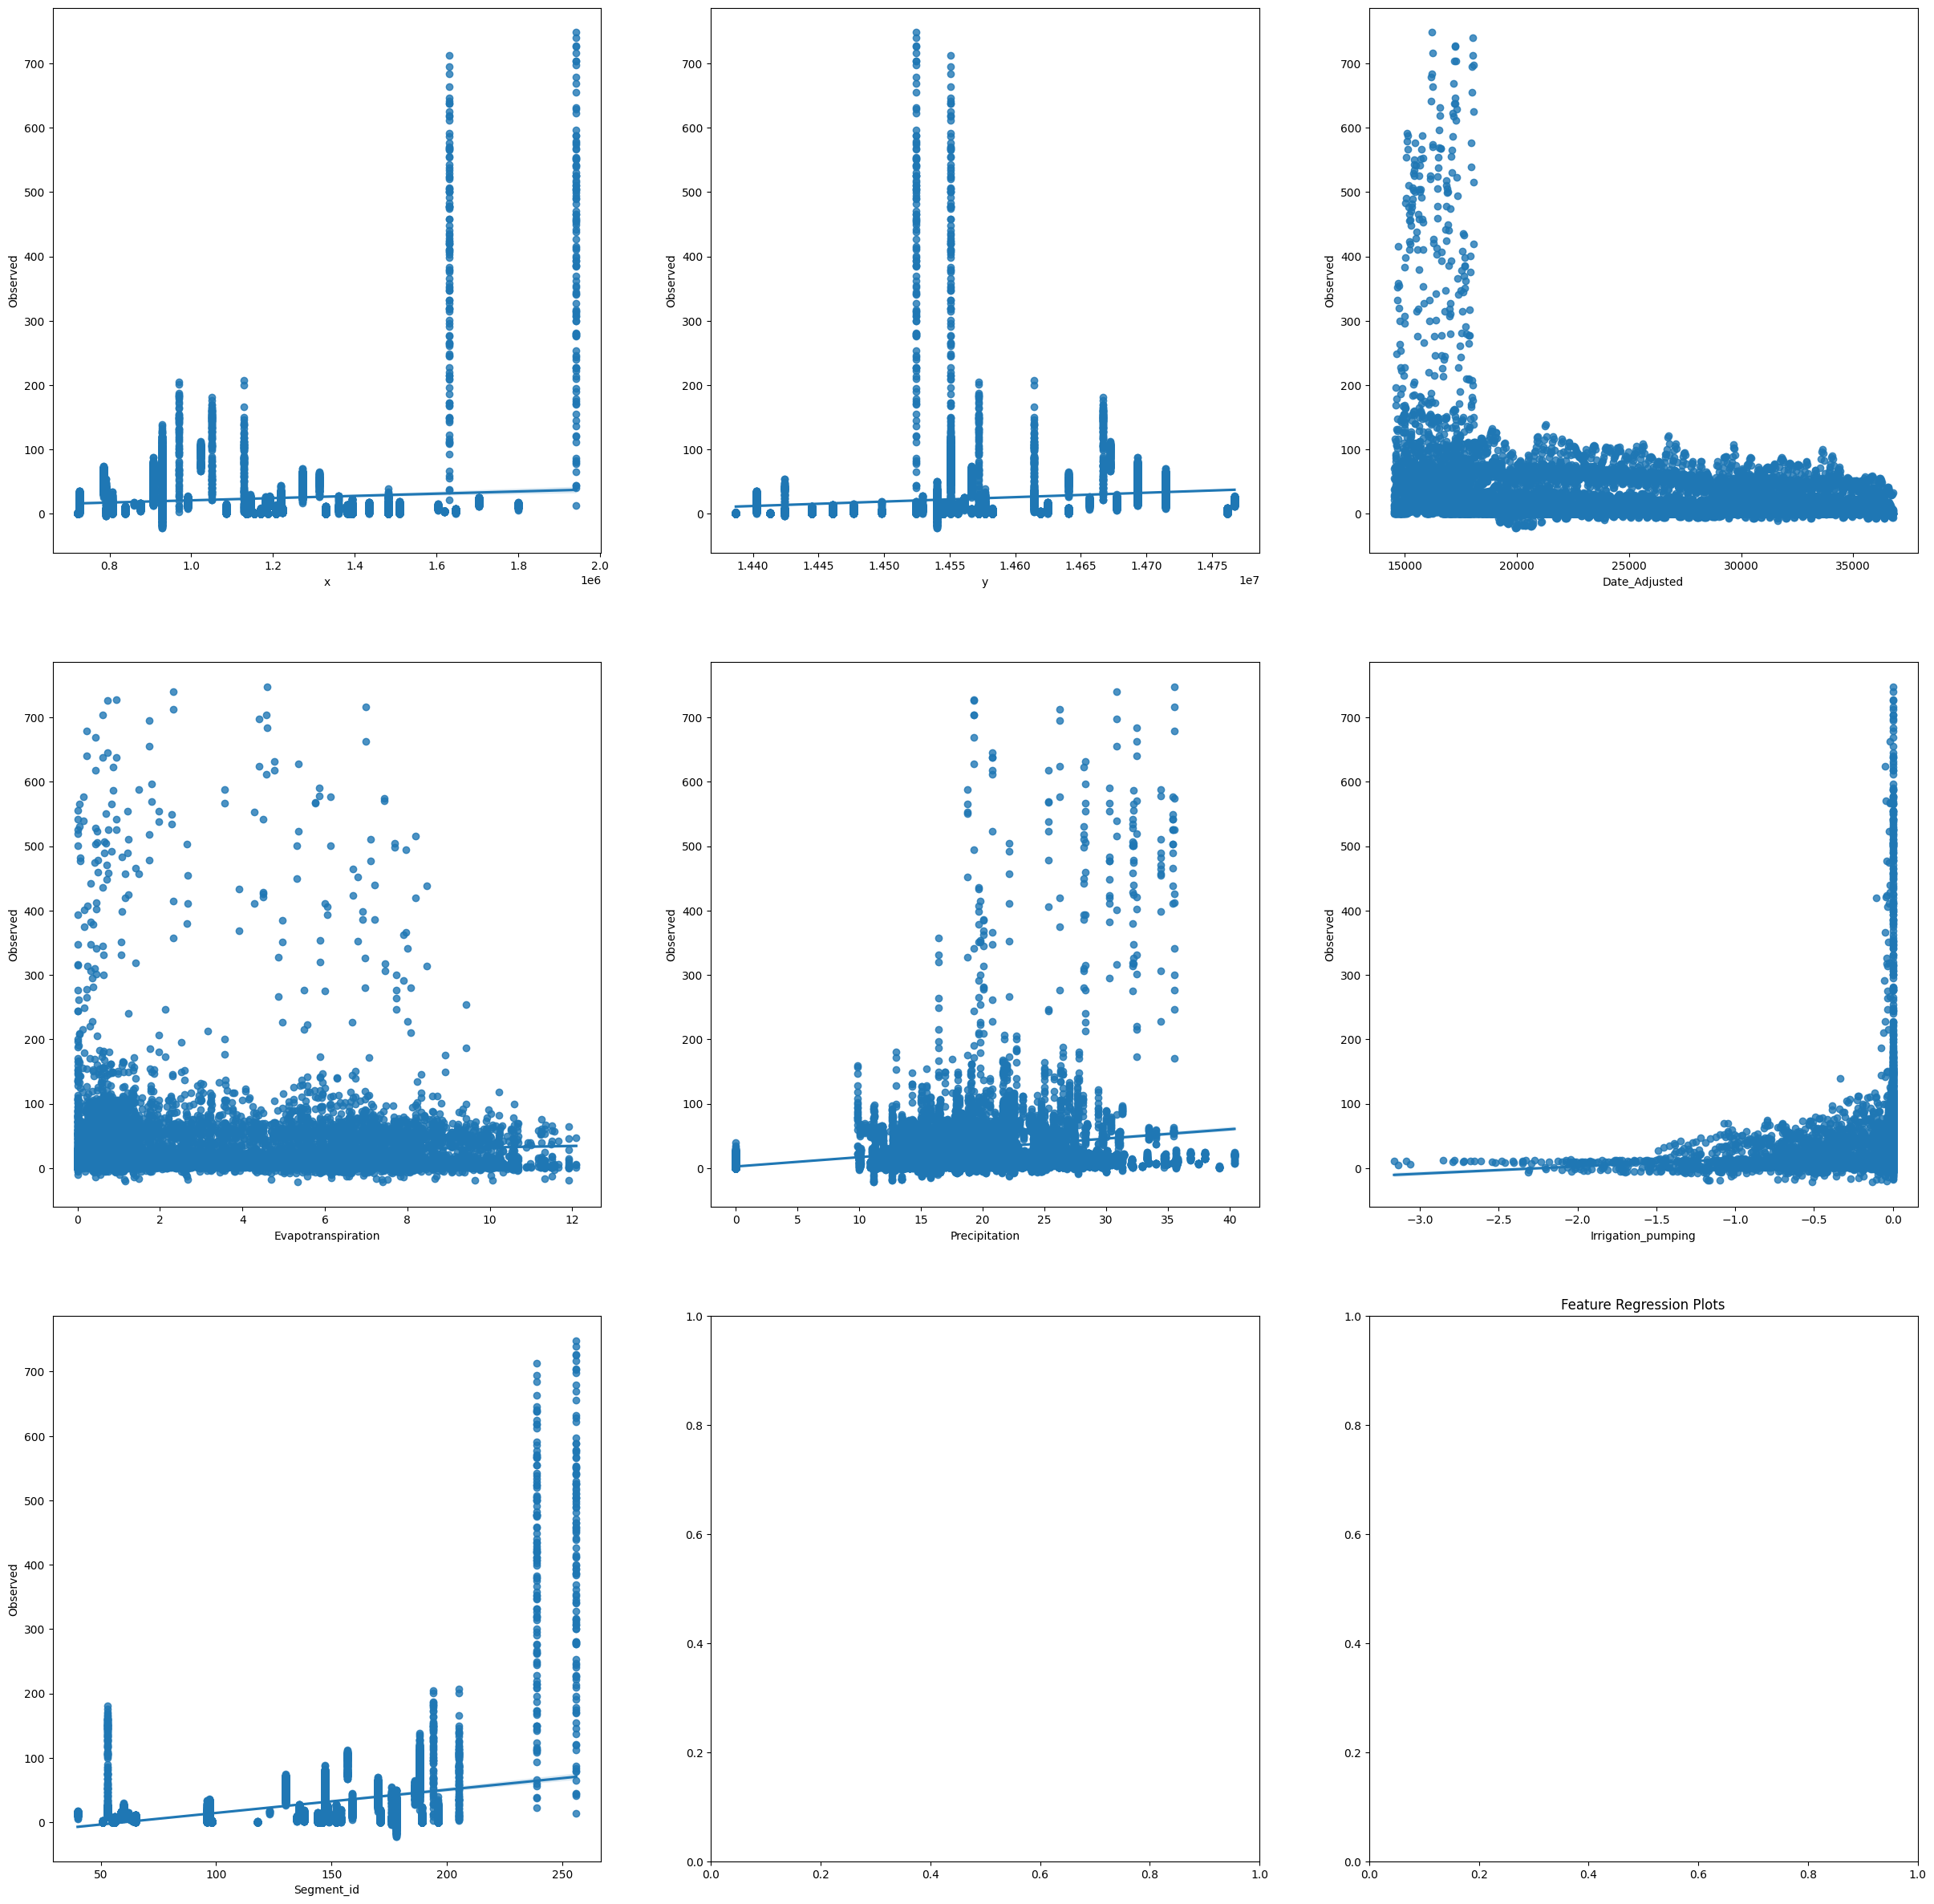

In [14]:
figs, axes = plt.subplots(3, 3, figsize=(30,30), sharex=False)
sns.regplot(data=baseflow, x='x', y='Observed', ax=axes[0,0])
sns.regplot(data=baseflow,x='y', y='Observed', ax=axes[0,1])
sns.regplot(data=baseflow,x='Date_Adjusted', y='Observed', ax=axes[0,2])
sns.regplot(data=baseflow,x='Evapotranspiration', y='Observed', ax=axes[1,0])
sns.regplot(data=baseflow,x='Precipitation', y='Observed', ax=axes[1,1])
sns.regplot(data=baseflow,x='Irrigation_pumping', y='Observed', ax=axes[1,2])
sns.regplot(data=baseflow,x='Segment_id', y='Observed', ax=axes[2,0])

## Using Position and Time as Features

In [30]:
feature_cols = ['x', 'y', 'Date_Adjusted', 'Evapotranspiration', 'Precipitation', 'Irrigation_pumping']
X = baseflow[feature_cols]
y = baseflow['Observed']
lm = LinearRegression()
lm.fit(X, y)

display(lm.intercept_)
display(list(zip(feature_cols, lm.coef_)))


292.86094410965495

[('x', 1.998063588068584e-05),
 ('y', -1.7917592069145662e-05),
 ('Date_Adjusted', -0.002089708025705074),
 ('Evapotranspiration', -0.7085010220089987),
 ('Precipitation', 1.5997603492462298),
 ('Irrigation_pumping', 4.137453961057423)]

## Monte-Carlo Cross Validation

In [42]:
def MonteCarloCrossValidation(iterations,X,y):
    trainX, testX, trainY, testY = train_test_split(X,y)
    averageError = 0
    for _ in range(iterations):
        model = LinearRegression()
        model.fit(trainX,trainY)
        predictY = model.predict(testX)
        # Get error/point of model
        errorPerPoint = 0
        for i in range(len(predictY)):
            errorPerPoint += (predictY[i] - testY.values[i]) ** 2
        errorPerPoint /= len(predictY)
        averageError += errorPerPoint
    # Divide by number of iterations to get average error
    averageError /= iterations
    print(averageError)
    return averageError

MonteCarloCrossValidation(10,X,y)

2619.5878232712885


2619.5878232712885

Feature 0: 88.406206
Feature 1: 128.178971
Feature 2: 688.372670
Feature 3: 44.316395
Feature 4: 938.321587
Feature 5: 33.784998


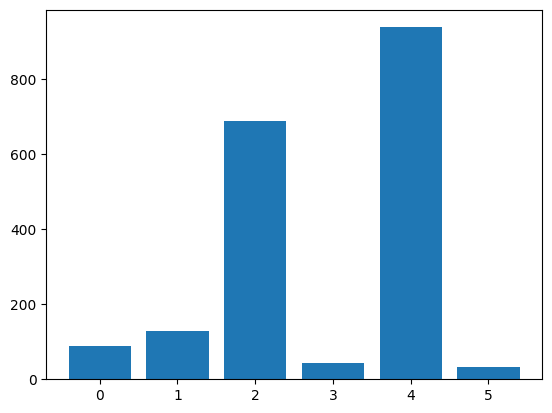

2200.25054150357
2891.3719336088975


2891.3719336088975

In [43]:


'''
From https://machinelearningmastery.com/feature-selection-for-regression-data/
By Jason Brownlee 
On August 18, 2020 
'''
def FeatureSelection(trainX, trainY, testX):
    fs = SelectKBest(score_func=f_regression, k='all')
    fs.fit(trainX,trainY)
    trainXFeatures = fs.transform(trainX)
    testXFeatures = fs.transform(testX)
    return trainXFeatures, testXFeatures, fs

feature_cols = ['x', 'y', 'Date_Adjusted', 'Evapotranspiration', 'Precipitation', 'Irrigation_pumping']
# feature_cols = ['Date_Adjusted', 'Precipitation']
X = baseflow[feature_cols]
y = baseflow['Observed']
trainX, testX, trainY, testY = train_test_split(X,y)
trainX, testX, fs = FeatureSelection(trainX, trainY, testX)

for i in range(len(fs.scores_)):
 print('Feature %d: %f' % (i, fs.scores_[i]))
# plot the scores
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()

feature_cols = ['Date_Adjusted', 'Precipitation']
Xbest = baseflow[feature_cols]
y = baseflow['Observed']

MonteCarloCrossValidation(100, X, y)
MonteCarloCrossValidation(100, Xbest, y)